<a href="https://colab.research.google.com/github/RO-AD/waymo-od-motion-pred/blob/main/tutorial/1_transformer/gp-transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer 실습
참고 : [Attention is All You Need Tutorial(ndb796)](https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Attention_is_All_You_Need_Tutorial_(German_English).ipynb)

자연어처리 끝판왕. 다른 분야에도 고르게 사용됨.

In [3]:
# 아,,, colab에서 UTF-8 오류 뜨는데 아래 코드로 해결함,,, 찝찝,,,,하네
import locale
locale.getpreferredencoding = lambda: "UTF-8"

## 자연어를 어떻게 Input으로 줄 수 있을까?
기본적으로 모델의 INPUT은 숫자 형태로 들어가기 때문에 처리하고자 하는 문장을 분해 및 숫자로 변환하는 전처리 작업이 필요하다. 이 과정을 문장의 토큰화(tokenization)이라고 한다.

**torchtext**는 자연어처리에 유용한 라이브러리로, 데이터셋과 전처리 클래스, 스코어링 함수 등이 존재한다. 설치해보자!

In [4]:
%%capture
!pip install torchtext==0.6.0

이번에는 **spaCy** 라이브러리를 이용해보자. **토큰화(tokenization), 태깅(tagging) 등의 전처리**를 위한 라이브러리다. 영어와 한국어 전처리 모듈을 설치하고 확인해보자

In [5]:
%%capture
!python -m spacy download en_core_web_sm
!python -m spacy download ko_core_news_sm

In [6]:
import spacy

spacy_en = spacy.load('en_core_web_sm') # 영어 토큰화(tokenization)
spacy_ko = spacy.load('ko_core_news_sm') # 한국어 토큰화(tokenization)

In [7]:
# 간단히 토큰화(tokenization) 기능 써보기
_tmp_en_tokens = spacy_en.tokenizer("I graduated last week.")
_tmp_ko_tokens = spacy_ko.tokenizer("저는 저번 주에 졸업했습니다.")

# 영어 문장 토큰화
for i, token in enumerate(_tmp_en_tokens):
    print(f"인덱스 {i}: {token.text}")

print("--------------")

# 한국어 문장 토큰화
for i, token in enumerate(_tmp_ko_tokens):
    print(f"인덱스 {i}: {token.text}")

인덱스 0: I
인덱스 1: graduated
인덱스 2: last
인덱스 3: week
인덱스 4: .
--------------
인덱스 0: 저는
인덱스 1: 저번
인덱스 2: 주에
인덱스 3: 졸업했습니다
인덱스 4: .


토큰화 과정을 함수화 해보자

In [8]:
tokenizer_en = lambda text: [token.text for token in spacy_en.tokenizer(text)]
tokenizer_ko = lambda text: [token.text for token in spacy_ko.tokenizer(text)]

In [9]:
tokenizer_en('I graduated last week.')

['I', 'graduated', 'last', 'week', '.']

필드(field)를 이용해 데이터셋에 대한 구체적인 전처리 과정을 명시할 수 있다. 이 작업을 통해 추후 코드에서 전처리를 조금 더 단순하게 다룰 수 있다.

In [10]:
from torchtext.data import Field

# 목표 : ko -> en 로 번역
src_field = Field(tokenize=tokenizer_ko, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)
trg_field = Field(tokenize=tokenizer_en, init_token="<sos>", eos_token="<eos>", lower=True, batch_first=True)

**Parameter**
- tokenize : 어떤 토큰화 함수를 적용할 것인지 지정(default : split)
- init_token : ?
- eos_token : ?
- lower : 대문자가 있다면 소문자로 변경할 것인지
- batch_first : ?(미니배치 차원을 맨 앞으로 하여 데이터를 불러올 것인지)

이제 데이터셋을 불러오자. **torchtext의 datasets**에는 대표적인 번역 데이터셋인 **Mullti30k**이 있다. 였는데,,, 아쉽게도 한국어는 없어서 다른 라이브러리를 사용함.

여러 데이터셋을 모아서 라이브러리화 하는 **Korpora**라는 라이브러리가 있었음

In [11]:
%%capture
!pip install Korpora

In [12]:
from Korpora import Korpora
Korpora.fetch("korean_parallel_koen_news")
datasets = Korpora.load("korean_parallel_koen_news")

[korean_parallel] download korean-english-park.train.tar.gz: 8.72MB [00:00, 70.0MB/s]                            


decompress /root/Korpora/korean_parallel/korean-english-park.train.tar.gz


[korean_parallel] download korean-english-park.dev.tar.gz: 115kB [00:00, 2.74MB/s]


decompress /root/Korpora/korean_parallel/korean-english-park.dev.tar.gz


[korean_parallel] download korean-english-park.test.tar.gz: 238kB [00:00, 6.65MB/s]


decompress /root/Korpora/korean_parallel/korean-english-park.test.tar.gz

    Korpora 는 다른 분들이 연구 목적으로 공유해주신 말뭉치들을
    손쉽게 다운로드, 사용할 수 있는 기능만을 제공합니다.

    말뭉치들을 공유해 주신 분들에게 감사드리며, 각 말뭉치 별 설명과 라이센스를 공유 드립니다.
    해당 말뭉치에 대해 자세히 알고 싶으신 분은 아래의 description 을 참고,
    해당 말뭉치를 연구/상용의 목적으로 이용하실 때에는 아래의 라이센스를 참고해 주시기 바랍니다.

    # Description
    Author : KakaoBrain
    Repository : https://github.com/jungyeul/korean-parallel-corpora
    References :
        - Jungyeul Park, Jeen-Pyo Hong and Jeong-Won Cha (2016) Korean Language Resources for Everyone.
          In Proceedings of the 30th Pacific Asia Conference on Language, Information and Computation
          (PACLIC 30). October 28 - 30, 2016. Seoul, Korea. 
          (https://www.aclweb.org/anthology/Y16-2002/)

    # License
    Creative Commons Attribution Noncommercial No-Derivative-Works 3.0
    Details in https://creativecommons.org/licenses/by-nc-nd/3.0/



In [13]:
datasets.train

koennews.train: size=94123
  - koennews.train.texts : list[str]
  - koennews.train.pairs : list[str]

In [14]:
datasets.test

koennews.test: size=2000
  - koennews.test.texts : list[str]
  - koennews.test.pairs : list[str]

불러온 데이터셋을 예제를 따라가기 편한 구조로 변경해주었다. 기존의 `torchtext.datasets.translation.Multi30k` 구조가 `torchtext.data.Example`의 집합을 `torchtext.data.Dataset`으로 묶어준 형태여서 이것을 그대로 재현했다.

In [15]:
from torchtext.data import Example

test_dataset_examples = []

for text, pair in zip(datasets.test.texts, datasets.test.pairs):
  example = Example.fromlist([text, pair], [("src", src_field), ("trg", trg_field)])
  test_dataset_examples.append(example)

train_dataset_examples = []

for text, pair in zip(datasets.train.texts, datasets.train.pairs):
  example = Example.fromlist([text, pair], [("src", src_field), ("trg", trg_field)])
  train_dataset_examples.append(example)

In [16]:
from torchtext.data import Dataset

train_dataset = Dataset(examples=train_dataset_examples, fields=[("src", src_field), ("trg", trg_field)])
test_dataset  = Dataset(examples=test_dataset_examples,  fields=[("src", src_field), ("trg", trg_field)])

In [17]:
# 학습 데이터 중 하나를 선택해 출력
print(vars(train_dataset.examples[30])['src'])
print(vars(train_dataset.examples[30])['trg'])

['어휘', ':']
['postal', 'service', '-', 'whose', 'postmaster', 'told', 'a', 'senate', 'panel', 'that', 'the', 'financial', 'impact', 'of', 'the', 'anthrax', 'crisis', 'could', 'be', 'several', 'billion', 'dollars', '-', 'uses', 'robots', 'to', 'sort', 'parcels', ',', 'but', 'other', 'automated', 'equipment', 'sorts', 'letters', '.']


이렇게 토큰화된 dataset을 구비했다. 이제 각 단어를 숫자 형태로 변경해주어야 한다. **Field**의 **build_vocab** 메서드를 이용해 사전을 만들 수 있고, 이를 기반으로 숫자로 변경한다.

In [18]:
src_field.build_vocab(train_dataset, min_freq=2)
trg_field.build_vocab(train_dataset, min_freq=2)

print(f"src vocab len : {len(src_field.vocab)}")
print(f"trg vocab len : {len(trg_field.vocab)}")

src vocab len : 96941
trg vocab len : 32910


**Parameter**
- min_freq : 최소 2번 이상 등장한 단어

In [19]:
trg_field.vocab.itos[4]

'the'

In [20]:
print(trg_field.vocab.stoi["hihihihi"]) # 없는 단어: 0
print(trg_field.vocab.stoi[trg_field.pad_token]) # 패딩(padding): 1
print(trg_field.vocab.stoi["<sos>"]) # : 2
print(trg_field.vocab.stoi["<eos>"]) # : 3
print(trg_field.vocab.stoi["a"])
print(trg_field.vocab.stoi["world"])

0
1
2
3
9
92


vocab 내에서 각 데이터를 숫자로 변환할 수 있는 것을 확인할 수 있었다. 그러나 각 문장 내 단어의 개수가 각기 다르기 때문에 BucketIterator를 이용하여 패딩을 포함한 동일한 개수로 맞춰줄 수 있다.
- 배치 크기(batch size): 128

In [21]:
import torch
from torchtext.data import BucketIterator

BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 일반적인 데이터 로더(data loader)의 iterator와 유사하게 사용 가능
train_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, test_dataset),
    batch_size=BATCH_SIZE,
    device=device)

In [22]:
for i, batch in enumerate(train_iterator):
    src = batch.src
    trg = batch.trg

    print(f"첫 번째 배치 크기: {src.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(src.shape[1]):
        print(f"인덱스 {i}: {src[0][i].item()}") # 여기에서는 [Seq_num, Seq_len]

    # 첫 번째 배치만 확인
    break

첫 번째 배치 크기: torch.Size([128, 43])
인덱스 0: 2
인덱스 1: 3247
인덱스 2: 0
인덱스 3: 0
인덱스 4: 5
인덱스 5: 29694
인덱스 6: 16
인덱스 7: 191
인덱스 8: 52780
인덱스 9: 5
인덱스 10: 55585
인덱스 11: 5
인덱스 12: 0
인덱스 13: 17
인덱스 14: 19693
인덱스 15: 4
인덱스 16: 3
인덱스 17: 1
인덱스 18: 1
인덱스 19: 1
인덱스 20: 1
인덱스 21: 1
인덱스 22: 1
인덱스 23: 1
인덱스 24: 1
인덱스 25: 1
인덱스 26: 1
인덱스 27: 1
인덱스 28: 1
인덱스 29: 1
인덱스 30: 1
인덱스 31: 1
인덱스 32: 1
인덱스 33: 1
인덱스 34: 1
인덱스 35: 1
인덱스 36: 1
인덱스 37: 1
인덱스 38: 1
인덱스 39: 1
인덱스 40: 1
인덱스 41: 1
인덱스 42: 1


## Multi Head Attention 아키텍처
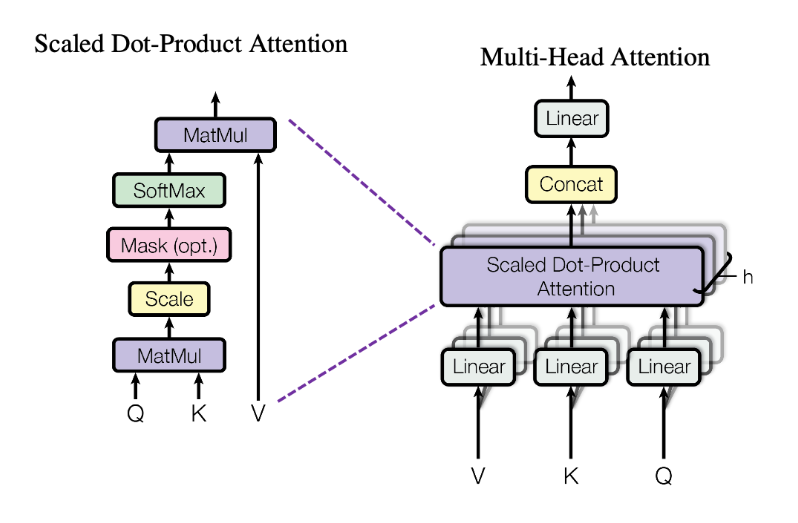
- Attention은 **Query, Key, Value**를 입력는다. 

In [28]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
  def __init__(self, hidden_dim=256, n_heads=8, dropout_ratio=0.1, device=device):
    '''
    [hyberparameter]
      - hidden_dim    : 하나의 단어에 대한 임베딩 차원
      - n_heads       : 헤드(head)의 개수
      - dropout_ratio : dropout 비율
    '''
    super().__init__()

    assert hidden_dim % n_heads == 0
    
    self.hidden_dim = hidden_dim # 임베딩 차원
    self.n_heads    = n_heads    # 헤드(각 attention)의 개수
    self.head_dim   = hidden_dim // n_heads # 각 헤드에서의 임베딩 차원

    # Input FC
    self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query FC
    self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key FC
    self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value FC

    # Output FC
    self.fc_o = nn.Linear(hidden_dim, hidden_dim)

    # Dropout
    self.dropout = nn.Dropout(dropout_ratio)

    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
  
  def forward(self, query, key, value, mask = None):
    batch_size = query.shape[0]

    Q = self.fc_q(query)
    K = self.fc_k(key)
    V = self.fc_v(value)

    # fc의 input/ouput의 차원이 같기 때문에 크기 변동 없음.
    # Q shape : [batch_size, query_len, hidden_dim]
    # K shape : [batch_size, key_len,   hidden_dim]
    # V shape : [batch_size, value_len, hidden_dim]

    # hidden_dim -> 헤드 개수만큼 {(n_heads) x (head_dim)} 형태로 변형
    #     .view()     ==> .reshape 같은 느낌
    #     .permute()  ==> 차원 순서 변경(?)
    Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

    # Q shape : [batch_size, n_heads, query_len, head_dim]
    # K shape : [batch_size, n_heads, key_len,   head_dim]
    # V shape : [batch_size, n_heads, value_len, head_dim]

    # Attention Energy 계산
    energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

    # energy shape : [batch_size, n_heads, query_len, key_len]
    
    # mask를 사용하는 경우
    if mask is not None:
      # mask 값이 0인 부분의 energy 값을 매우 작게 만들어주기
      energy = energy.masked_fill(mask==0, -1e10)

    # attention score
    attention = torch.softmax(energy, dim=-1) # 확률값

    # attention shape (변동없음) : [batch_size, n_heads, query_len, key_len]

    # Scaled Dot-Product Attention 계산
    x = torch.matmul(self.dropout(attention), V)

    # x shape : [batch_size, n_heads, query_len, head_dim]

    # .contiguous() : 축 변경은 해당되는 정보만 변경되고, 메모리 상에서의
    #                 구조가 바뀌지 않음. 근데 두 번 이상 변경하면 문제 발생.
    #                 복제하는 방식으로 해결해 주는 듯.
    x = x.permute(0, 2, 1, 3).contiguous()

    # x shape : [batch_size, query_len, n_heads, head_dim]

    x = x.view(batch_size, -1, self.hidden_dim)

    # x shape : [batch_size, query_len, hidden_dim]

    x = self.fc_o(x)

    # x shape : [batch_size, query_len, hidden_dim]

    return x, attention

    

In [24]:
MultiHeadAttentionLayer()

MultiHeadAttentionLayer(
  (fc_q): Linear(in_features=256, out_features=256, bias=True)
  (fc_k): Linear(in_features=256, out_features=256, bias=True)
  (fc_v): Linear(in_features=256, out_features=256, bias=True)
  (fc_o): Linear(in_features=256, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

한줄평 : 흐름은 이해가 됐는데, 차원 변환이 이해가 안된다,,,

## Position-wise Feedforward 아키텍처
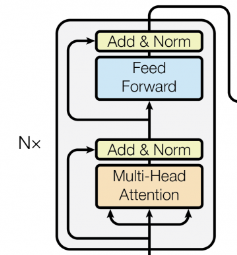

- Encoder 내부는 두개의 로직으로 이루어져있다. 위 사진은 Encoder 부분만 잘라낸 것이며, Multi-Head Attention을 거친 다음 진행되는 파란색 Feed Forward 로직이 이번 블록에서 작업할 **Position-wise Feedforward** 아키텍처다.
- FF 앞에 Position-wise가 붇는 이유는 Multi-Head Attention의 output이 각 단어(position)에 대한 정보이기 때문에 각 position에 대해 적용되는 FF라고 보면 된다. 

- 입력과 출력 차원이 동일하다

In [29]:
class PositionwiseFeedforwardLayer(nn.Module):
  def __init__(self, hidden_dim, pf_dim, dropout_ratio):
    '''
    [hyperparameter]
      - hidden_dim    : 하나의 단어에 대한 임베딩 차원
      - pf_dim        : feedforward 레이어에서의 내부 임베딩 차원
      - dropout_ratio : dropout 비율
    '''
    super().__init__()

    self.fc_1 = nn.Linear(hidden_dim, pf_dim)
    self.fc_2 = nn.Linear(pf_dim, hidden_dim)

    self.dropout = nn.Dropout(dropout_ratio)

  def forward(self, x):

    # x shape : [batch_size, seq_len, hidden_dim]

    x = self.dropout(torch.relu(self.fc_1(x)))

    # x shape : [batch_size, seq_len, pf_dim]

    x = self.fc2(x)

    # x shape : [batch_size, seq_len, hidden_dim]
    
    return x

## Encoder Layer 아키텍처
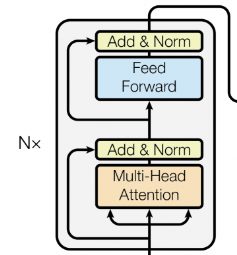
- Transformer는 Encoder를 여러번 중첩해서 사용한다.
  - Encoder 그림 좌측에 있는 **Nx**가 이를 뜻함. N번 반복한다.
- 그렇게 사용하기 위해서는 입력과 출력의 차원이 같아야 한다.

In [30]:
class EncoderLayer(nn.Module):
  def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
    '''
    [hyperparameter]
      - hidden_dim    : 하나의 단어에 대한 임베딩 차원
      - n_heads       : 헤드(head)의 개수 = scaled dot-product attention의 개수
      - pf_dim        : Feedforward 레이어에서의 내부 임베딩 차원
      - dropout_ratio : dropout 비율
    '''
    super().__init__()
    
    self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
    self.self_attention_norm = nn.LayerNorm(hidden_dim)

    self.position_wise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
    self.position_wise_feedforward_norm = nn.LayerNorm(hidden_dim)
    
    self.dropout = nn.Dropout(dropout_ratio)
    
  def forward(self, src, src_mask):

    # src shape      : [batch_size, src_len, hidden_dim]
    # src_mask shape : [batch_size, src_len]
    
    # self attention
    #   Option. 필요한 경우 mask 행렬을 이용하여 attention할 단어를 조절 가능
    _src, _ = self.self_attention(src, src, src, src_mask)

    # Multi-Head Attention 직후에 오는 'Add & Norm' 부분 구현
    #   - residual 한 구조를 띔(빠른 수렴).
    src = self.self_attention_norm(src + self.dropout(_src))

    # src shape : [batch_size, src_len, hidden_dim]

    # position-wise feedforward
    _src = self.positionwise_feedforward(src)

    # 마찬가지로 'Add & Norm'.
    src = self.position_wise_feedforward_norm(src + self.dropout(_src))

    return src



## Encoder 아키텍처
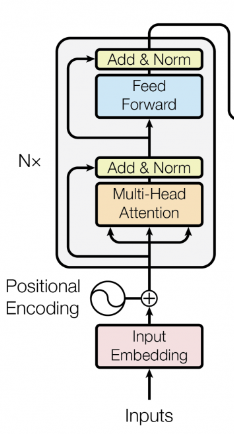
- 드디어 Encoder. Embedding 후 Encoder Layer를 중첩시키면 된다.
- 원본 논문에서는 positional embedding을 sin/cos 함수를 사용했는데, 여기서는 학습하는 형태로 구현.
  - BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식

In [31]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
    '''
    [hyperparameter]
      - input_dim     : 하나의 단어에 대한 원 핫 인코딩 차원
      - hidden_dim    : 하나의 단어에 대한 임베딩 차원
      - n_layers      : 내부적으로 사용할 인코더 레이어의 개수 (Nx)
      - n_heads       : 헤드(head)의 개수 = scaled dot-product attention의 개수
      - pf_dim        : Feedforward 레이어에서의 내부 임베딩 차원
      - dropout_ratio : dropout 비율
      - max_length    : 문장 내 최대 단어 개수
    '''
    super().__init__()

    self.device = device

    self.token_embedding    = nn.Embedding(input_dim, hidden_dim)
    self.position_embedding = nn.Embedding(max_length, hidden_dim)

    self.encoder_layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

    self.dropout = nn.Dropout(dropout_ratio)

    self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

  def forward(self, src, src_mask):

      # src: [batch_size, src_len]
      # src_mask: [batch_size, src_len]

      batch_size = src.shape[0]
      src_len    = src.shape[1]

      # positional encoding
      pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

      # pos: [batch_size, src_len]

      # input embedding 값과 position embedding을 더해서 최종 input 형성
      src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

      # src: [batch_size, src_len, hidden_dim]

      # encoder layer를 순차적으로 거침
      for layer in self.encoder_layers:
        src = layer(src, src_mask)

      return src # 마지막 레이어의 출력 반환



## Transformer
- `<pad>` 토큰에 대해 mask 값을 0으로 설정.

In [ ]:
# tutorial/1_transformer/gp-transformer.ipynb